In [11]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

import os

import shutil
from collections import Counter
import numpy as np
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

p=46

In [12]:
# Load data
df = pd.read_csv("final_transformed_data_188.csv")
patient_ids = df["patientunitstayid"]
# Create binary target Y
df["Y"] = (df["unitvisitnumber"] ).astype(float)

# Separate features (X) and target (y)
df=df.drop(columns=["patientunitstayid"])
X = df.drop(["unitvisitnumber", "Y"], axis=1)
y = df["Y"].values-1
from sklearn.model_selection import StratifiedKFold

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store the splits
splits = []

# Perform 5-fold cross-validation
for train_idx, test_idx in skf.split(X, y):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    id_train, id_test = patient_ids[train_idx], patient_ids[test_idx]
    
    # Append the split to the list
    splits.append((X_train, X_test, y_train, y_test, id_train, id_test))

# Now `splits` contains 5 tuples, each with (X_train, X_test, y_train, y_test, id_train, id_test)

class SampleSet:
    def __init__(self, index,X, Y,id,module='Bernoulli'):
        """
        Initializes the SampleSet with n samples and p features for X.
        Y is generated based on the conditional probability P(Y=1|X).
        """
        self.index=index
        self.n=X.shape[0]
        self.p=X.shape[1]
        self.X = X
        self.Y = Y
        self.id=id
        self.subtrain=None
        self.subval=None
        self.counts=None
        self.r=int(self.n**index)

    

    def get_sample_set(self):
        """Returns the main sample set (X, Y)."""
        return self.X, self.Y
    
    def get_sub_samples_with_validation(self, B):
        """
        Generates B sub-sample sets, each containing r samples randomly selected 
        from the main sample set, along with corresponding validation sets.
        
        Also counts the number of times each index is selected across all B sub-samples.
        
        Returns:
            train_samples: List of tuples, each containing (train_X, train_Y, train_indices)
            validation_samples: List of tuples, each containing (val_X, val_Y, val_indices)
            selection_counts: Dictionary with counts of each index's appearance in the B sub-samples.
        """
        train_samples = []
        validation_samples = []
        selection_counts = Counter()  # To track appearances of each index
        indices = torch.arange(self.n)
        self.B=B
        for _ in range(B):
            # Randomly select r unique indices for the sub-sample
            selected_indices = indices[torch.randperm(self.n)[:self.r]]
            
            # Update selection count for each index
            selection_counts.update(selected_indices.tolist())
            
            # Get validation indices (those not in selected_indices)
            val_indices = torch.tensor([i for i in indices if i not in selected_indices])

            # Separate sub-sample and validation sets, including original indices
            X_sub = self.X[selected_indices]
            Y_sub = self.Y[selected_indices]
            X_val = self.X[val_indices]
            Y_val = self.Y[val_indices]
            
            # Append to train_samples and validation_samples lists
            train_samples.append((X_sub, Y_sub, selected_indices))
            validation_samples.append((X_val, Y_val, val_indices))
        self.subtrain=train_samples
        self.subval=validation_samples
        self.counts=dict(selection_counts)
        return train_samples, validation_samples, dict(selection_counts)
    
    def save(self, file_path):
        """Saves the SampleSet instance to a file."""
        torch.save(self, file_path)

    @staticmethod
    def load(file_path):
        """Loads a SampleSet instance from a file."""
        return torch.load(file_path,weights_only=False)


# Column indices (0-based)

X_train=splits[0][0]
X_test=splits[0][1]
y_train=splits[0][2]
y_test=splits[0][3]
id_train=splits[0][4]
id_test=splits[0][5]

sample_set = SampleSet(0.9,X_train,y_train,id_train,module='Bernoulli')


/home/xuranm/.local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [13]:
### Read the results and combine them into a DataFrame
import os
import torch
import pandas as pd
B=3000
# Define paths
results_folder = 'results188/'  # Folder where results are stored
sample_set_folder = 'sampleset/188/'  # Folder where sample sets are stored

# Initialize an empty DataFrame to store all results
combined_results = pd.DataFrame()

# Loop through all 5 folders (i=0 to i=4)
for i in range(5):
    print(f"Processing folder {i}...")

    # Load the results for the current folder
    results_path = os.path.join(results_folder, f'resultspoi{p}RF{B}_folder{i}.pth')
    if not os.path.exists(results_path):
        print(f"Results file {results_path} not found. Skipping...")
        continue

    results = torch.load(results_path)
    y_test = results['y_test']  # Ground truth labels for the test set
    hatf_B = results['hatf_B']
    sd_f = results['sd_f']
    sd_f_c = results['sd_f_c']

    # Load the corresponding test sample set
    test_sample_set_path = os.path.join(sample_set_folder, f'sampleset{p}poisson{B}_testfolder{i}.pth')
    if not os.path.exists(test_sample_set_path):
        print(f"Test sample set file {test_sample_set_path} not found. Skipping...")
        continue

    sample_set_test = sample_set.load(test_sample_set_path)
    id_test = sample_set_test.id  # IDs of the test samples
    y_testtrue = sample_set_test.Y  # Ground truth labels for the test set

    # Combine the data into a DataFrame for the current folder
    folder_results = pd.DataFrame({
        'id_test': id_test,
        'y_testtrue': y_test,
        'y_test': y_test,  #Double check, y_test must be the same as y_testtrue
        'hatf_B': hatf_B,
        'sd_f': sd_f,
        'sd_f_c': sd_f_c
    })

    # Append the folder results to the combined DataFrame
    combined_results = pd.concat([combined_results, folder_results], ignore_index=True)

# Save the combined results to a CSV file (optional)
combined_results.to_csv(f'combined_resultsRFpoi{p}.csv', index=False)
print("Combined results saved to 'combined_results.csv'.")

# Display the combined DataFrame


Processing folder 0...
Processing folder 1...
Processing folder 2...
Processing folder 3...
Processing folder 4...
Combined results saved to 'combined_results.csv'.


Lift curve saved to lift_curve_poissonRF46.pdf


0.7378660480505369

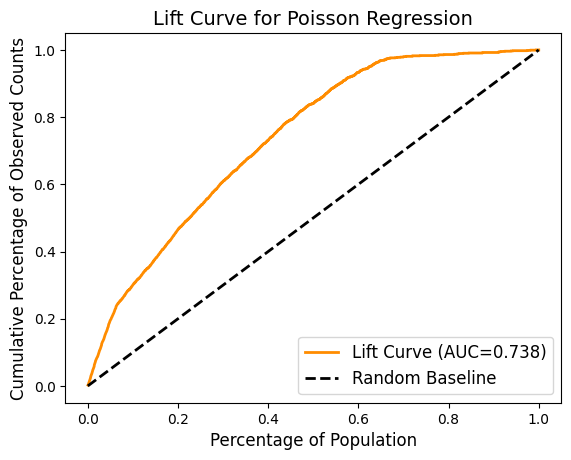

In [15]:
combined_results= pd.read_csv(f'combined_resultsRFpoi{p}.csv')
#This is the ROC curve
combined_results = combined_results[combined_results['id_test'] != 989395]

# Convert the filtered data to tensors
hatf_B = torch.tensor(combined_results['hatf_B'].values)
sd_f = torch.tensor(combined_results['sd_f'].values)
sd_f_c = torch.tensor(combined_results['sd_f_c'].values)
y_test = torch.tensor(combined_results['y_test'].values)
id_test = torch.tensor(combined_results['id_test'].values)

import torch
import matplotlib.pyplot as plt
from sklearn.metrics import auc  # 用来计算 AUC 曲线下面积

def plot_lift_curve(pred, y, save_path="lift_curve.pdf"):
    """
    Generate and save the Lift Curve for Poisson regression, with AUC value.
    
    Parameters:
        pred (torch.Tensor or array-like): Predicted expected counts (output of the Poisson regression model).
        y (torch.Tensor or array-like): Observed counts (ground truth).
        save_path (str): Path to save the lift curve figure.
    
    Returns:
        float: AUC value under the lift curve.
    """
    # Ensure inputs are torch tensors
    pred = torch.tensor(pred, dtype=torch.float32) if not isinstance(pred, torch.Tensor) else pred
    y = torch.tensor(y, dtype=torch.float32) if not isinstance(y, torch.Tensor) else y
    
    # Sort predictions and corresponding observed counts in descending order
    sorted_indices = torch.argsort(pred, descending=True)
    sorted_pred = pred[sorted_indices]
    sorted_y = y[sorted_indices]
    
    # Compute cumulative sums of observed counts and total counts
    cumulative_observed = torch.cumsum(sorted_y, dim=0)
    total_observed = torch.sum(y)
    cumulative_percentage_observed = cumulative_observed / total_observed
    
    # Compute percentage of population covered
    n = len(pred)
    percentage_population = torch.arange(1, n + 1, dtype=torch.float32) / n
    
    # Compute AUC under lift curve
    lift_auc = auc(percentage_population.numpy(), cumulative_percentage_observed.numpy())
    
    # Plot the lift curve
    plt.plot(percentage_population.numpy(), cumulative_percentage_observed.numpy(), label=f"Lift Curve (AUC={lift_auc:.3f})", color="darkorange", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Baseline")
    plt.title("Lift Curve for Poisson Regression", fontsize=14)
    plt.xlabel("Percentage of Population", fontsize=12)
    plt.ylabel("Cumulative Percentage of Observed Counts", fontsize=12)
    plt.legend(fontsize=12)
    
    # Save the figure
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Lift curve saved to {save_path}")
    # plt.close()

    return lift_auc
plot_lift_curve(hatf_B, y_test, save_path=f"lift_curve_poissonRF{p}.pdf")

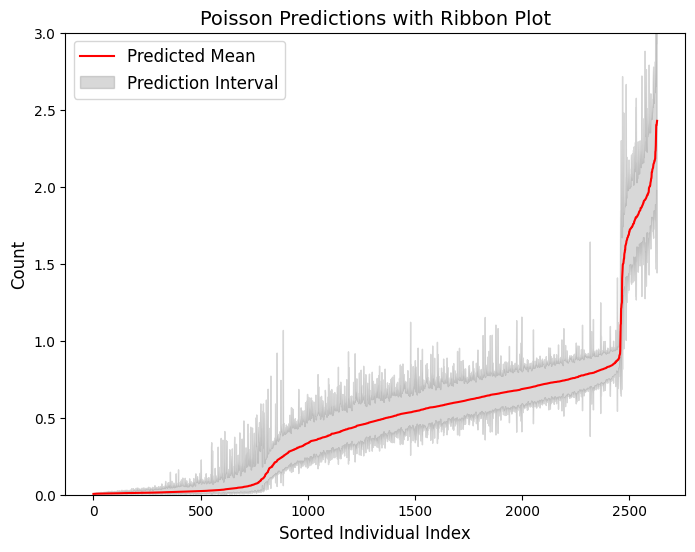

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- Assume these tensors are already defined ---
# hatf_B: predicted log-counts (log \lambda) from your Poisson model
# sd_f: estimated standard deviations for the predictions
# y_test_tensor: observed counts
# For demonstration purposes, here's some example data (remove these if using your own):
# hatf_B = torch.randn(100)
# sd_f = torch.abs(torch.randn(100)) * 0.1
# y_test_tensor = torch.randint(0, 10, (100,))

# --- Compute the lower and upper prediction bounds and estimated \lambda ---
lower_p = torch.exp(hatf_B - 1.96 * sd_f_c).numpy()  # Lower bound of the prediction interval
upper_p = torch.exp(hatf_B + 1.96 * sd_f_c).numpy()  # Upper bound of the prediction interval
estimated_lbd = torch.exp(hatf_B).numpy()               # Predicted counts (λ)
y_true = y_test.cpu().numpy() if y_test.is_cuda else y_test.numpy()

# Sort individuals by predicted lambda for a smoother ribbon plot
sorted_indices = np.argsort(estimated_lbd)

sorted_estimated = estimated_lbd[sorted_indices]
sorted_lower = lower_p[sorted_indices]
sorted_upper = upper_p[sorted_indices]
sorted_y = y_true[sorted_indices]
individual_indices = np.arange(len(estimated_lbd))

plt.figure(figsize=(8, 6))
plt.plot(individual_indices, sorted_estimated, 'r-', label='Predicted Mean')
plt.fill_between(individual_indices, sorted_lower, sorted_upper, color='gray', alpha=0.3, label='Prediction Interval')
# plt.scatter(individual_indices, sorted_y, color='blue', marker='x', label='Observed $y$')
plt.xlabel('Sorted Individual Index',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.ylim(0, 3)
plt.title('Poisson Predictions with Ribbon Plot',fontsize=14)
plt.legend(loc='upper left',fontsize=12)
plt.savefig(f'individual_poissonRF{p}.pdf',bbox_inches='tight')
plt.show()

In [6]:
(sorted_upper-sorted_lower).std()

np.float64(0.27351885031249656)